# Heatmap Visualization of CNN 

In [1]:
import torch 
from torch import nn
from torchvision import models, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
from io import BytesIO
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [4]:
import requests
from io import BytesIO

def load_img(url, device = device):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])


    res = requests.get(url)
    image = Image.open(BytesIO(res.content)).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    return image

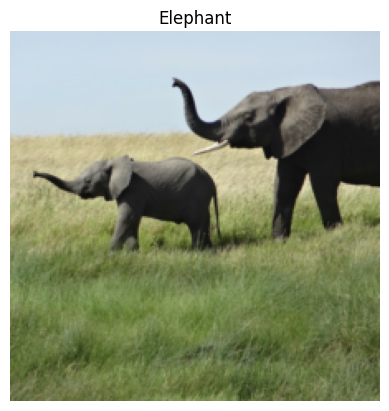

In [5]:
url = "https://img-datasets.s3.amazonaws.com/elephant.jpg"
img = load_img(url)

plt.imshow(img[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("Elephant")
plt.show()


In [6]:
pred = resnet(img)
pred.shape


torch.Size([1, 1000])

In [10]:
list(resnet.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

## To generate the heatmap, we need
1. last convolutional layer
2. grad of the last convolutional layer
3. Average pooling of the grad to get the importance and weighing the feature map with that
4. Superimpose the input image with the heatmap

In [23]:
class GradCAM:
    def __init__(self, model, last_layer):
        self.model = model
        self.features = None
        self.gradient = None

        last_layer.register_forward_hook(self._save_activation())
        last_layer.register_full_backward_hook(self._save_gradient())
    
    def _save_activation(self):
        def hook(model, input, output):
            self.features = output
        return hook
    
    def _save_gradient(self):
        def hook(model, input, output):
            self.gradient = output[0]
        return hook

    def __call__(self, X, class_idx= None):
        """
            Get feature map and gradient
            if no class idx, get the index of highest logit as the class index
            Return:
                heatmap
        """

        #Forward pass to register forward pass 
        self.model.eval()
        logits = self.model(X)
        
        if not class_idx:
            class_idx = torch.argmax(logits)
        
        self.model.zero_grad()
        score = logits[:, class_idx]
        
        #Backward pass to register backward pass
        score.backward()

        feature_maps = self.features.detach() # 1, C, H, W
        grad = self.gradient.detach()

        weights = torch.mean(grad, dim=(0, 2, 3))

        cam = weights.view(-1, 1, 1) * feature_maps.squeeze(0) #C, H, W

        heatmap = torch.mean(cam, dim=0)
        heatmap = torch.relu(heatmap)
        heatmap /= torch.max(heatmap)

        return heatmap.detach().cpu().numpy()


In [25]:
last_layer  = resnet.layer4[-1].conv3

CAM = GradCAM(resnet, last_layer)
heatmap = CAM(img)
heatmap.shape

(7, 7)

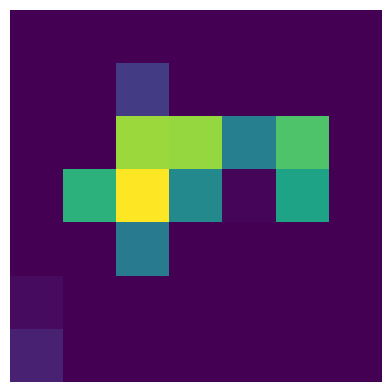

In [29]:
plt.matshow(heatmap)
plt.axis('off')
plt.show()

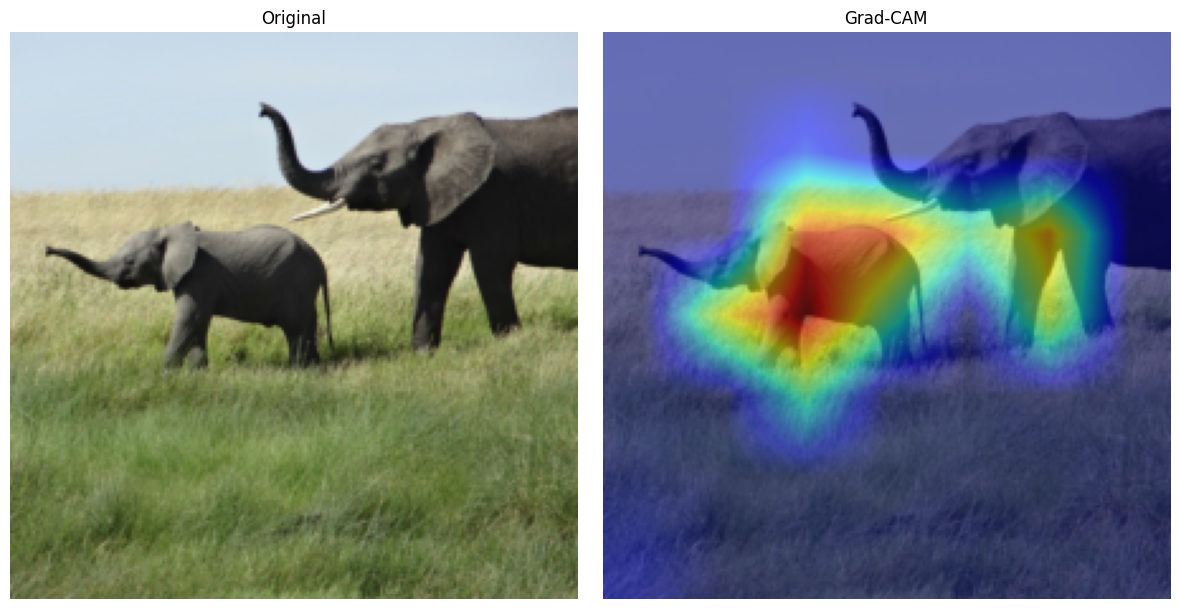

In [34]:
cam_resized = Image.fromarray(heatmap)
cam_resized = cam_resized.resize((224, 224), Image.BILINEAR)
cam_np = np.array(cam_resized)

# Overlay on image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img[0].detach().cpu().numpy().transpose(1, 2, 0))
plt.imshow(cam_np, cmap='jet', alpha=0.5)
plt.title("Grad-CAM")
plt.axis("off")
plt.tight_layout()
plt.savefig("grad_cam_result.jpg", dpi=150)
plt.show()


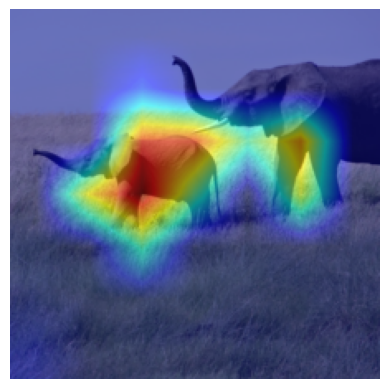

In [ ]:
#Just testing CV2
import cv2
def show_cam_on_image(img, mask):
    mask_resized = cv2.resize(mask, (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

cam_image = show_cam_on_image(img[0].detach().cpu().numpy().transpose(1,2,0), heatmap)
plt.imshow(cam_image)
plt.axis('off')
plt.show()